In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, VARIABLES_PATTERN, K, N, P

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2025-01-02 14:49:15,613 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata2/variables=[0,2]
2025-01-02 14:49:15,614 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata2/variables=[0,2]
2025-01-02 14:49:15,614 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata2/variables=[0,2]


Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata2/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata2/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata2/variables=[0,2]


In [2]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)


[   30    63    90 ... 99871 99921 99960]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


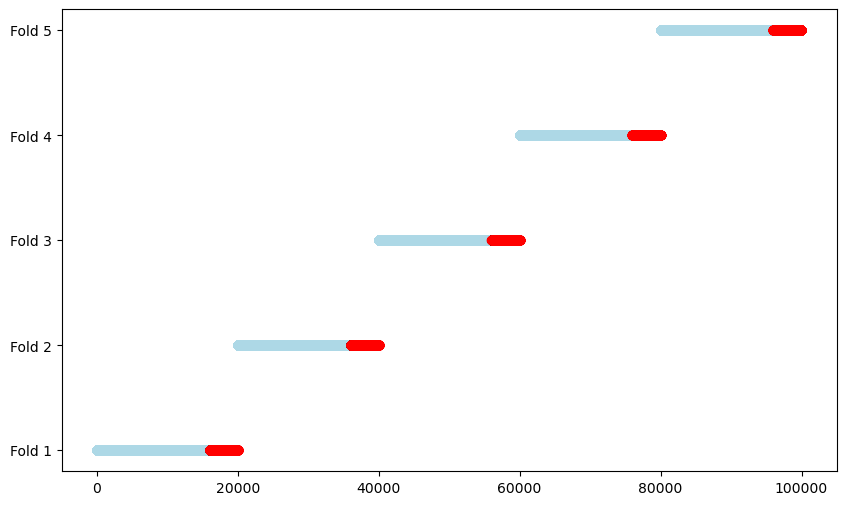

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, y = create_dataset(data, lookback_period, step, forecast_period, motif_indexes)

#X_series is (num_samples, lookback_period, num_features)
X_mask = np.zeros((X_series.shape[0], X_series.shape[1])) 

for i, obs_motif_indexes in enumerate(X_indices):
    for j, idx in enumerate(obs_motif_indexes):
        idx = int(idx)
        X_mask[i, idx:idx+P] = 1

X_mask = torch.tensor(X_mask, dtype=torch.float32)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([19972, 100, 3])
X_mask shape: torch.Size([19972, 100])
X_indices shape: torch.Size([19972, 4, 1])
y shape: torch.Size([19972, 1])


Number of finished trials:  100
Best trial: 89
Best hyperparameters: {'learning_rate': 0.0005642498730440528, 'num_layers': 4, 'batch_size': 16, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 256}
Validation Losses: [63.613, 64.021, 60.2, 65.686, 66.195]
Mean validation loss: 63.943
Test Losses: [116.538, 104.249, 99.632, 95.792, 116.802]
Mean test loss: 106.603
Mean test MAE: 7.174 std: 0.241
Mean test RMSE: 10.316 std: 0.418


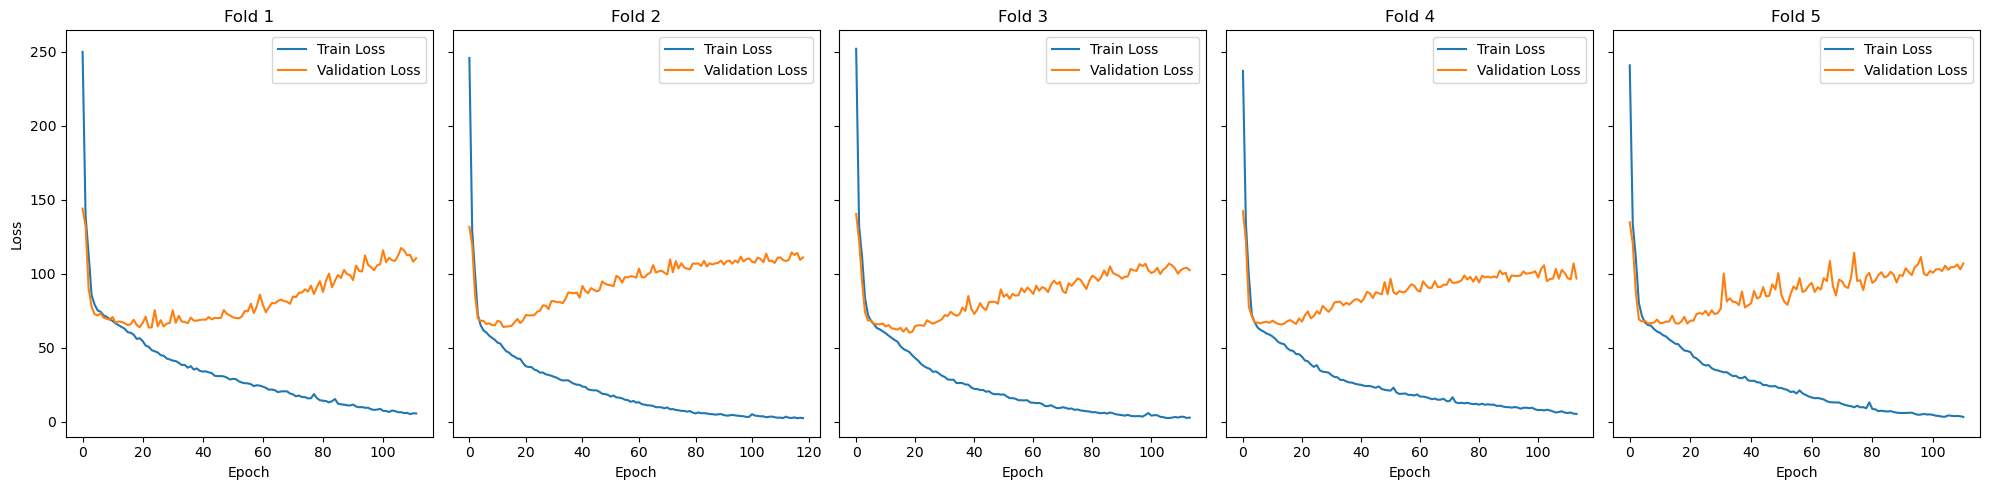

In [6]:
from models.ffnn_pytorch import FFNN
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "FFNN"
model_name = "FFNNSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

#run_optuna_study(pipeline.run_cross_val, FFNN, model_type, suggestion_dict, model_params_keys, seed, [X_series], y, [True], model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


Best hyperparameters: {'learning_rate': 0.0006014660377442742, 'num_layers': 4, 'batch_size': 16, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 128, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 256}
Early stopping at epoch 125, with best epoch being 19
Early stopping at epoch 119, with best epoch being 7
Early stopping at epoch 118, with best epoch being 21
Early stopping at epoch 116, with best epoch being 21
Early stopping at epoch 117, with best epoch being 15
Validation Losses: [89.73470306396484, 91.92015838623047, 83.09198760986328, 90.05851745605469, 97.14669036865234]
Mean validation loss: 90.39041137695312
Test Losses: [182.82257080078125, 158.62144470214844, 138.01373291015625, 126.88150787353516, 159.7202911376953]
Mean test loss: 153.21190948486327


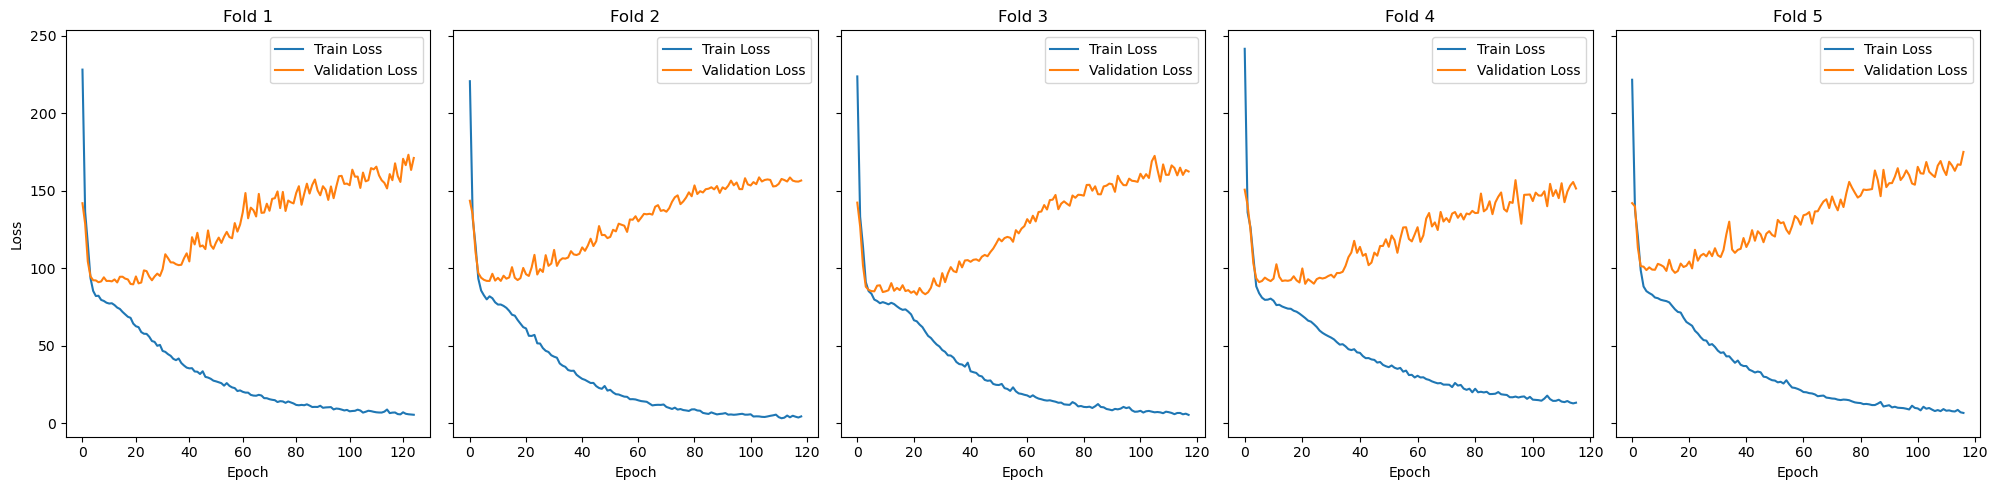

In [7]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, FFNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_series], y=y, normalize_flags=[True])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

#Plot the predictions vs true values for each fold
# for fold in range(5):
#    plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))

# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()



Number of finished trials:  100
Best trial: 14
Best hyperparameters: {'learning_rate': 0.0008402014117166218, 'num_layers': 2, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 256}
Validation Losses: [57.188, 58.837, 56.34, 57.353, 59.075]
Mean validation loss: 57.759
Test Losses: [78.142, 83.782, 66.75, 80.71, 87.722]
Mean test loss: 79.421
Mean test MAE: 6.292 std: 0.108
Mean test RMSE: 8.903 std: 0.406


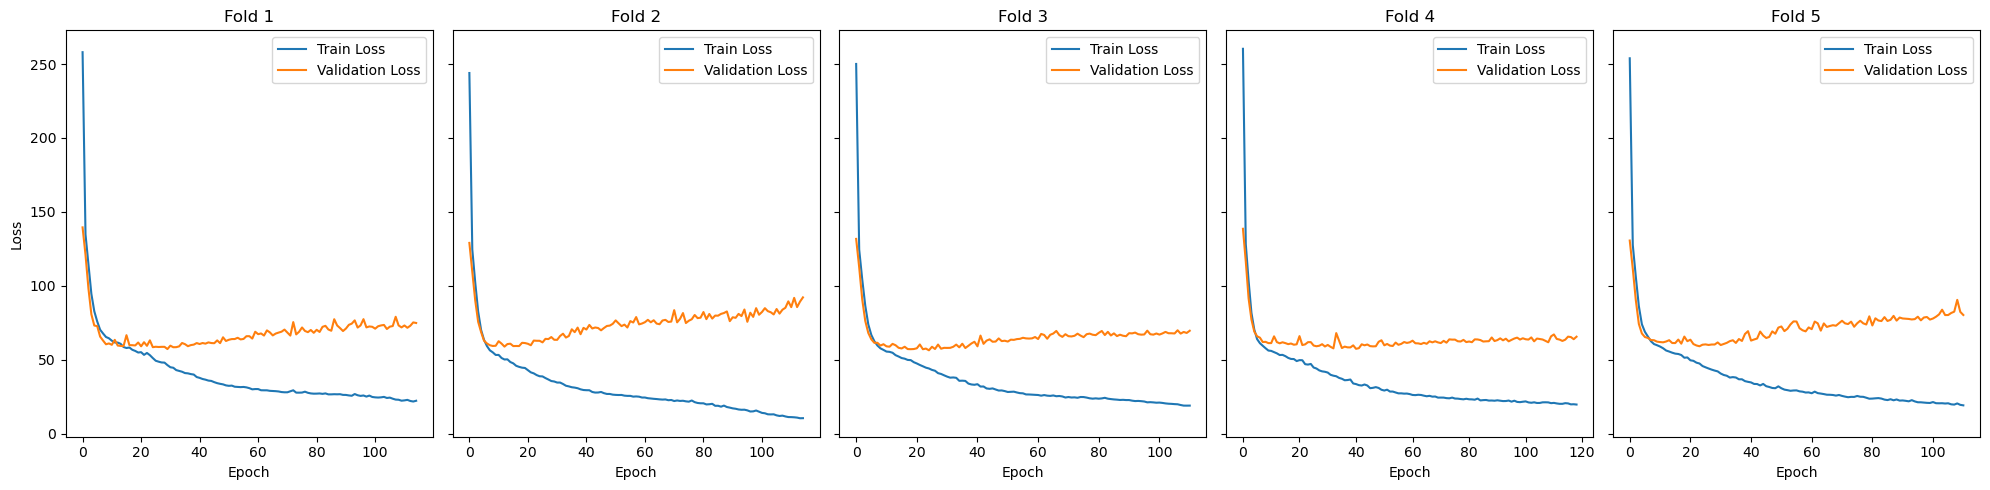

In [7]:
from models.ffnn_pytorch import FFNN
from utils.train_pipeline import run_optuna_study
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline

n_trials = 100
num_epochs = 500
model_type = "FFNN"
model_name = "FFNNSeries_Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4, 5]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]

model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

#run_optuna_study(pipeline.run_cross_val, FFNN, model_type, suggestion_dict, model_params_keys, seed, [X_series, X_mask], y, [True, False], model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


Best hyperparameters: {'learning_rate': 0.0008838150680575805, 'num_layers': 5, 'batch_size': 32, 'hidden_size_layer_0': 16, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 256, 'hidden_size_layer_3': 256, 'hidden_size_layer_4': 128}
Early stopping at epoch 112, with best epoch being 13
Early stopping at epoch 115, with best epoch being 7
Early stopping at epoch 111, with best epoch being 7
Early stopping at epoch 114, with best epoch being 8
Early stopping at epoch 111, with best epoch being 17
Validation Losses: [68.51646423339844, 76.23040008544922, 66.92023468017578, 67.84722137451172, 81.33062744140625]
Mean validation loss: 72.16898956298829
Test Losses: [120.24354553222656, 131.307373046875, 107.68732452392578, 117.1613540649414, 133.15122985839844]
Mean test loss: 121.91016540527343


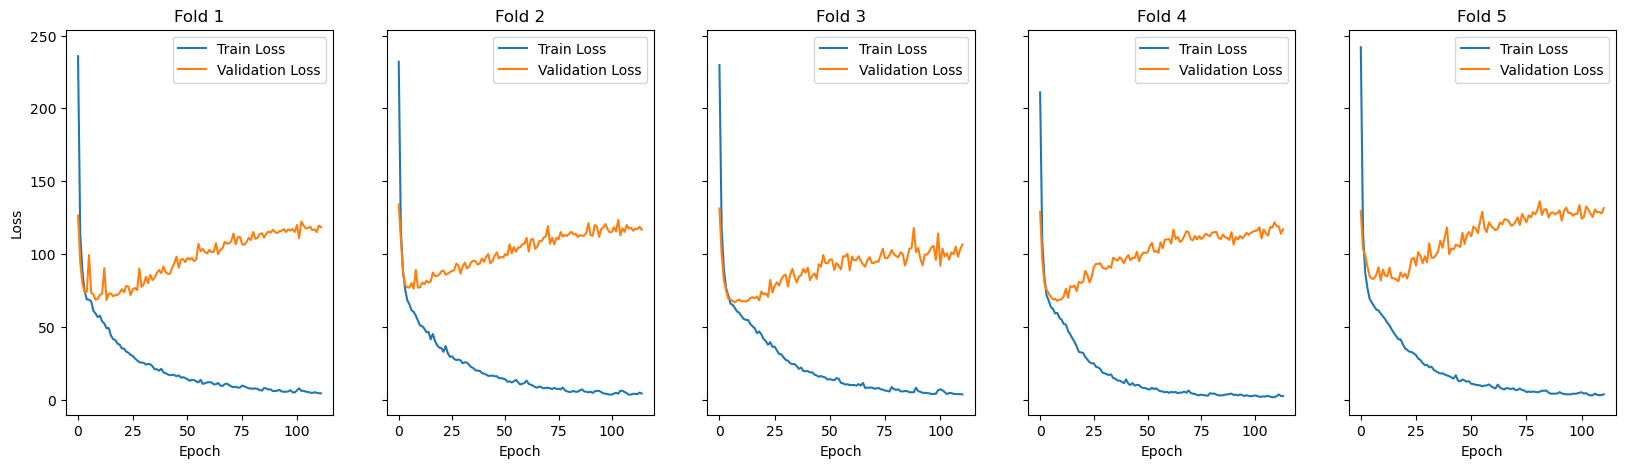

In [9]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, FFNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_series, X_mask], y=y, normalize_flags=[True, False])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


Number of finished trials:  100
Best trial: 62
Best hyperparameters: {'learning_rate': 0.0002636578878682208, 'num_layers': 4, 'batch_size': 16, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 256, 'hidden_size_layer_3': 256}
Validation Losses: [44.136, 40.216, 38.522, 44.699, 40.901]
Mean validation loss: 41.695
Test Losses: [47.87, 54.883, 50.208, 43.348, 47.523]
Mean test loss: 48.766
Mean test MAE: 5.837 std: 0.353
Mean test RMSE: 6.978 std: 0.269


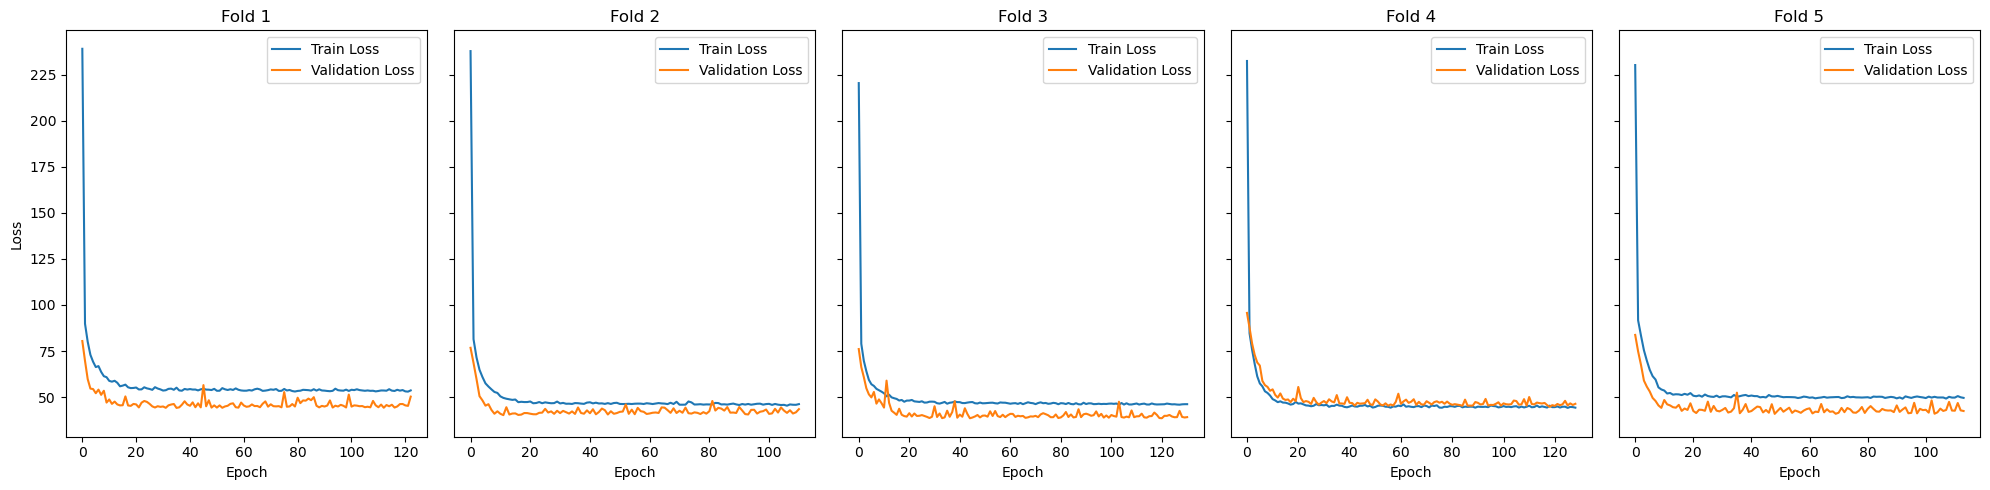

In [8]:
from models.ffnn_pytorch import FFNN
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "FFNN"
model_name = "FFNNIndexes"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

#run_optuna_study(pipeline.run_cross_val, FFNN, model_type,suggestion_dict,  model_params_keys, seed, [X_indices], y, [True], model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))

Best hyperparameters: {'learning_rate': 0.0008360226372563064, 'num_layers': 4, 'batch_size': 16, 'hidden_size_layer_0': 256, 'hidden_size_layer_1': 256, 'hidden_size_layer_2': 64, 'hidden_size_layer_3': 256}
Early stopping at epoch 124, with best epoch being 21
Early stopping at epoch 137, with best epoch being 43
Early stopping at epoch 140, with best epoch being 129
Early stopping at epoch 121, with best epoch being 59
Early stopping at epoch 120, with best epoch being 97
Validation Losses: [45.758399963378906, 48.82056427001953, 40.57882308959961, 41.933170318603516, 50.974788665771484]
Mean validation loss: 45.61314926147461
Test Losses: [48.44881057739258, 52.593135833740234, 50.638458251953125, 55.359230041503906, 52.98916244506836]
Mean test loss: 52.00575942993164


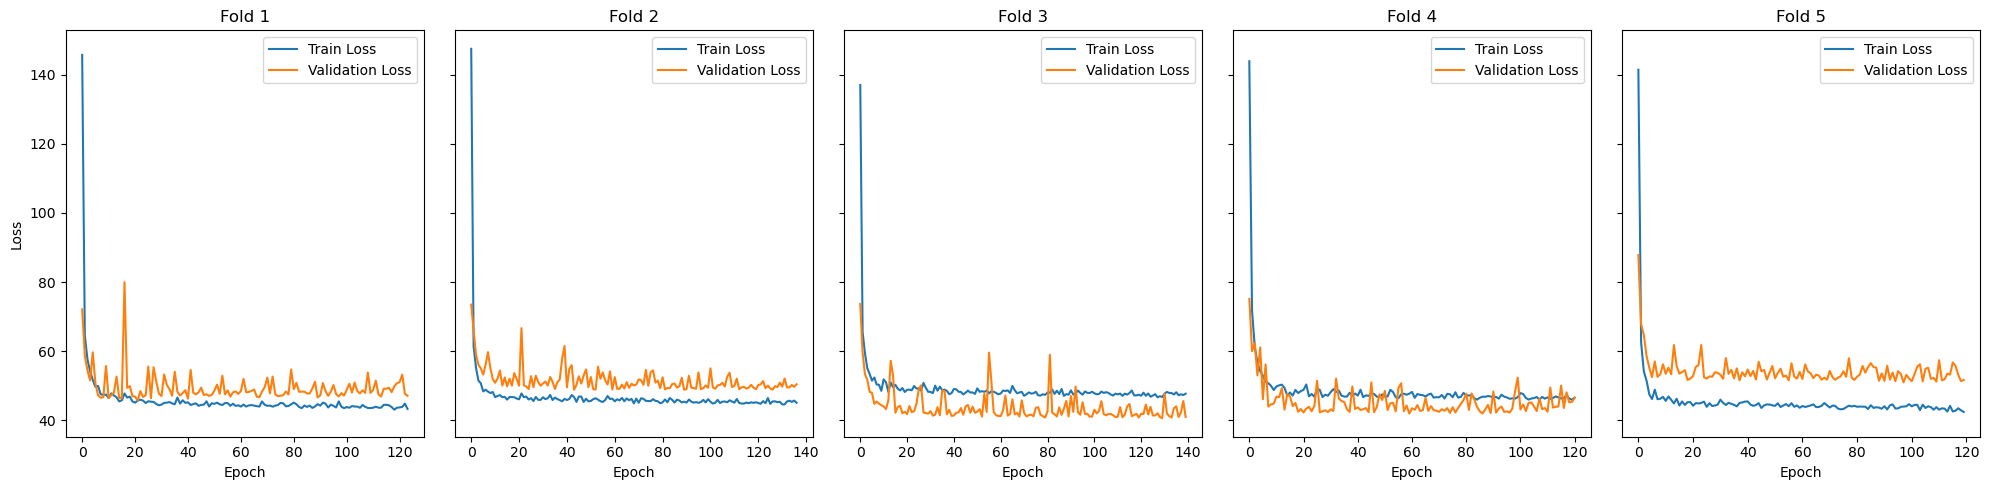

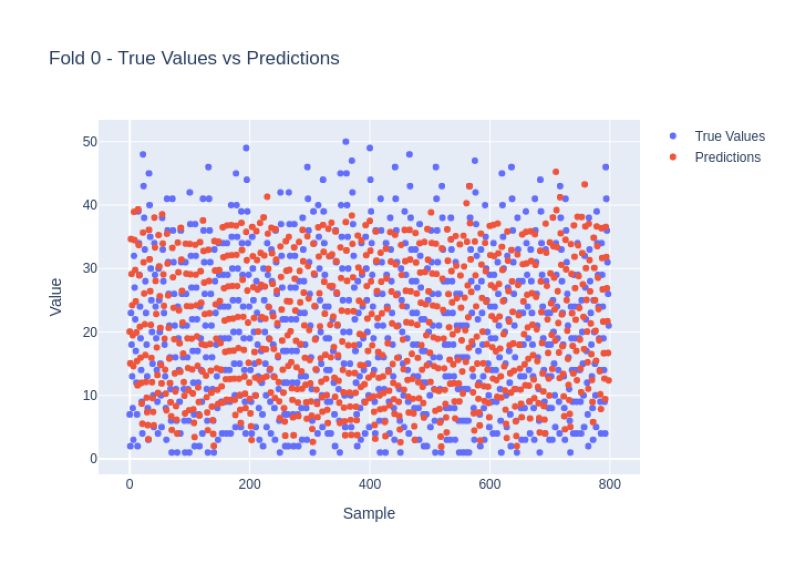

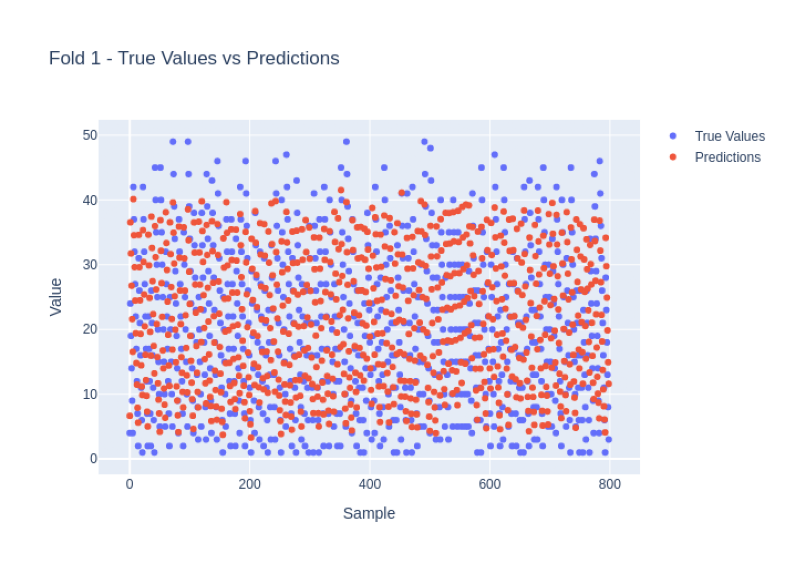

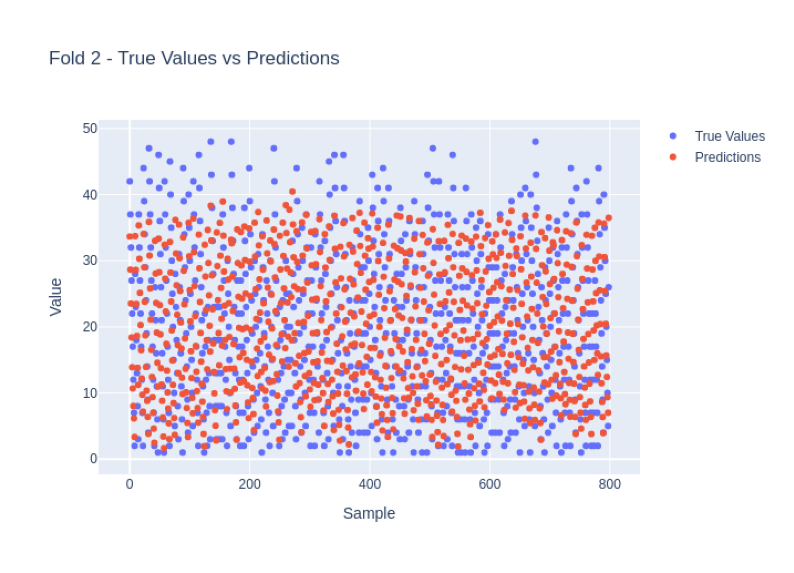

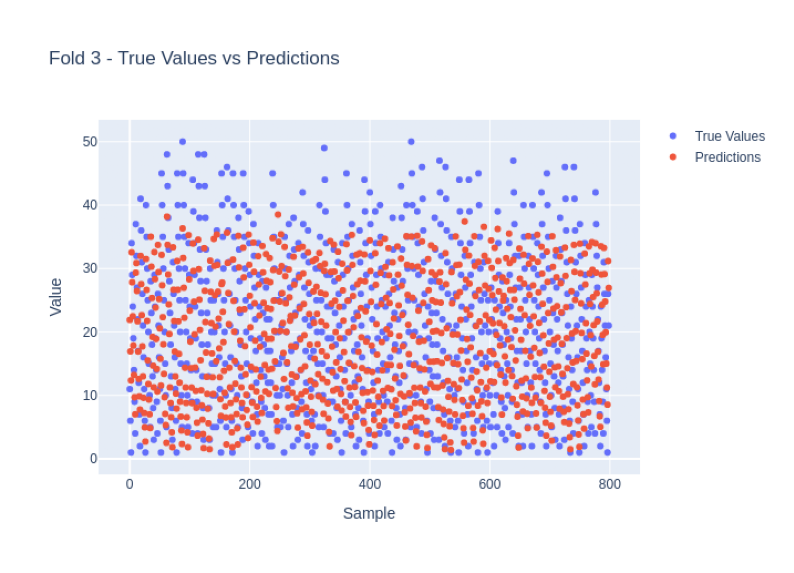

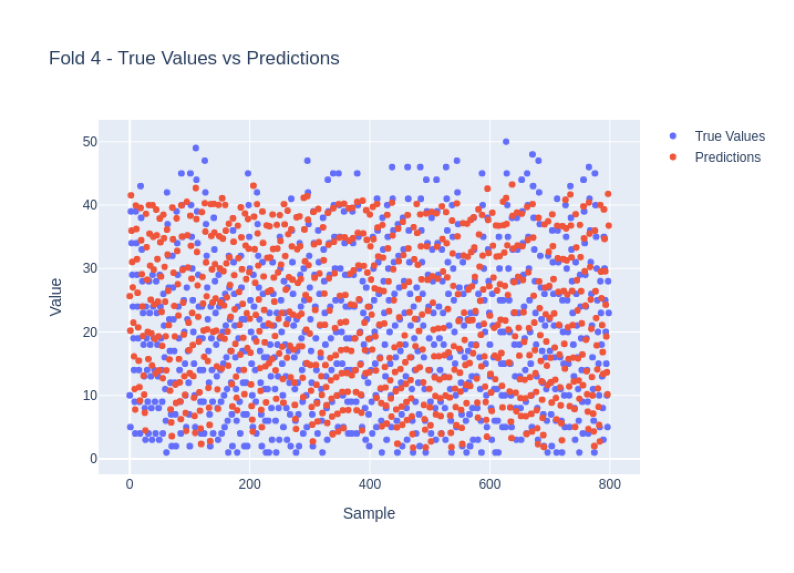

In [11]:
from utils.utils import plot_preds_vs_truevalues
from utils.train_pipeline import get_preds_best_config


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, FFNN, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_indices], y=y, normalize_flags=[True])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

#Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


# for fold in range(5):
#     img = mpimg.imread(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


In [12]:
# from models.ffnn_pytorch import FFNN
# from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline

# n_trials = 100
# num_epochs = 500
# model_type = "FFNN"
# model_name = "FFNNSeries_Masking_Indexes"

# suggestion_dict = {
#     "learning_rate": {
#         "type": "float",
#         "args": [1e-5, 1e-3], 
#         "kwargs": {"log": True} 
#     },
#     "num_layers": {
#         "type": "categorical",
#         "args": [[1, 2, 3, 4, 5]] 
#     },        
#     "batch_size": {
#         "type": "categorical",
#         "args": [[16, 32, 64, 128]] 
#     }
# }

# model_params_keys = ["hidden_sizes_list"]

# #X1 shape is (num_samples, lookback_period, num_features)
# masking_X1 = np.zeros((X1.shape[0], X1.shape[1])) 

# for i, obs_motif_indexes in enumerate(X2):
#     for j, idx in enumerate(obs_motif_indexes):
#         masking_X1[i, idx.item():idx.item()+p] = 1

# masking_X1 = torch.tensor(masking_X1, dtype=torch.float32)


# model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
# os.makedirs(model_results_dir, exist_ok=True)  

# run_optuna_study(pipeline.run_cross_val, FFNN, model_type, suggestion_dict, model_params_keys, seed, [X1, masking_X1, indexes], y, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

# study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
# print_study_results(study)
# plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
